# 1. Setting up the environment

## 1.1 Checking if the notebook was launched in the correct environment

In [1]:
#prints the available list of environments with asterisk (*) next to the current environment
#need to relaunch jupyter if launched in incorrect environment
!conda env list

# conda environments:
#
base                     C:\Users\Sarthak\anaconda3
prom02_env            *  C:\Users\Sarthak\anaconda3\envs\prom02_env
prot_env                 C:\Users\Sarthak\anaconda3\envs\prot_env



## 1.2 Installing the required packages in the environment

In [2]:
#prints the list of installed packages in the environment
#useful for checking versions and confirming if the packages have successfully installed
!conda list

# packages in environment at C:\Users\Sarthak\anaconda3\envs\prom02_env:
#
# Name                    Version                   Build  Channel
_tflow_select             2.3.0                     eigen  
absl-py                   0.13.0           py38haa95532_0  
aiohttp                   3.7.4            py38h2bbff1b_1  
argon2-cffi               20.1.0           py38h2bbff1b_1  
astor                     0.8.1            py38haa95532_0  
astunparse                1.6.3                      py_0  
async-timeout             3.0.1            py38haa95532_0  
async_generator           1.10               pyhd3eb1b0_0  
attrs                     21.2.0             pyhd3eb1b0_0  
backcall                  0.2.0              pyhd3eb1b0_0  
blas                      1.0                         mkl  
bleach                    4.0.0              pyhd3eb1b0_0  
blinker                   1.4              py38haa95532_0  
blosc                     1.21.0               h19a0ad4_0  
bottleneck        

In [3]:
#installing the packages - pandas and matplotlib
import sys
!conda install --yes --prefix {sys.prefix} pandas
!conda install --yes --prefix {sys.prefix} matplotlib

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\Sarthak\anaconda3\envs\prom02_env

  added / updated specs:
    - pandas


The following NEW packages will be INSTALLED:

  blas               pkgs/main/win-64::blas-1.0-mkl
  bottleneck         pkgs/main/win-64::bottleneck-1.3.2-py38h2a96729_1
  intel-openmp       pkgs/main/win-64::intel-openmp-2021.3.0-haa95532_3372
  mkl                pkgs/main/win-64::mkl-2021.3.0-haa95532_524
  mkl-service        pkgs/main/win-64::mkl-service-2.4.0-py38h2bbff1b_0
  mkl_fft            pkgs/main/win-64::mkl_fft-1.3.0-py38h277e83a_2
  mkl_random         pkgs/main/win-64::mkl_random-1.2.2-py38hf11a4ad_0
  numexpr            pkgs/main/win-64::numexpr-2.7.3-py38hb80d3ca_1
  numpy              pkgs/main/win-64::numpy-1.20.3-py38ha4e8547_0
  numpy-base         pkgs/main/win-64::numpy-base-1.20.3-py38hc2deb75_0
  pandas             pkgs/main/win-64::pandas-1.3.1-py38h6214cd6_0
  pytz               pkgs/main/noarc

In [3]:
#seting the backend of matplotlib to the 'inline' backend, so the plots are shown in the notebook
%matplotlib inline

## 1.3 Importing the installed packages in the environment

In [4]:
#importing the packages in the environment for use

import glob #module for matching pathnames to a specified pattern
import os #module allowing interaction with the file system
import itertools #module that provides functions that work on iterators to produce complex iterators
import random #module's sample function to randomly select a file from a list of files
import shutil #module offering a number of high-level operations on files such as move or copy

import pandas as pd #module for data manipulation and analysis 
import matplotlib.pyplot as plt #library for creating visualizations

# 2. Declaring variables, constants for paths and regex patterns

In [5]:
RAW_DIR = 'MRL_DS_RAW' #directory from where the images for each subject (37 in total) is obtained
CAT_DIR = 'MRL_DS_CAT' #directory where selected images are categorised by state i.e., open or closed for training
SUB_DIR = 'PART_' #partial path holder for storing multiple sub-datasets

MAX_NUM_FILES = 50 #threshold for max. files allowed for each category
MAX_DATASETS = 3 #threshold for max. datasets to be created

In [6]:
#regex entry to get the list of all files
all_files_regex = '*\\*.png'
per_subject_regex = 's00??'

In [7]:
#paths for processing files
all_files_path = f'{RAW_DIR}\\{all_files_regex}'
per_subject_path = f'{RAW_DIR}\\{per_subject_regex}\\'
per_dataset_path = f'{CAT_DIR}\\{SUB_DIR}'

# 3. Defining functions for manipulating dataframes and creating a dataset

## 3.1 Function to get file count for each attribute category

In [8]:
def get_pattern_count(dir_list, pattern_list):
    #getting count of files for each category
    pattern_file_count = []
    
    #loop through each pattern in the list
    for pattern in pattern_list:
        #get file count against each pattern
        file_count = len(glob.glob(f'{dir_list}\\{pattern}'))
        #append the count for each pattern
        pattern_file_count.append([pattern, file_count])
    
    #adding column names to the dataframe
    pattern_file_count = pd.DataFrame(pattern_file_count, columns=['regex_pattern','file_count'], index = None)
    
    return pattern_file_count

## 3.2 Function to create dataframes based on specific criteria

In [9]:
def get_combined_df(parent_df, selector_attribute, list_of_columns, groupby_clause, possible_values):
    combined_df = pd.DataFrame()
    
    #looping through all possible values for selected column/category e.g. say gender, we will get '0' for male and '1' for female
    for key in possible_values.keys():
        #filtering the dataframe for just male and female counts against 'selector_attribute' i.e., eye-state
        per_value_df = parent_df[parent_df[selector_attribute] == key][list_of_columns].groupby(groupby_clause).count()
        #renaming the column name from saying gender to male/female i.e. the specific attribute
        per_value_df = per_value_df.rename({selector_attribute : possible_values[key]}, axis=1)
        #combining the male data frame and then female on axis=1 i.e., on the column side
        combined_df = pd.concat([combined_df, per_value_df], axis=1)
        
    return combined_df

## 3.3 Function to create random datasets

In [10]:
def create_dataset(num_datasets, from_path, to_path, category_size, regex_list):
    for i in range(0, num_datasets):
        total_random_files = []
        #index for file name e.g. PART_x where x = 1,2 and so on till specified in 'num_datasets'
        dir_index = i+1

        #looping through each pattern in regex patterns list
        for p in regex_list:
            #getting all files matching the pattern
            all_files = glob.glob(f'{from_path}\\{p}')
            #getting the count for files available for that pattern if less than 'category_size' then that many files we get
            #however, if more than only get 'category_size' number of files i.e. 50
            num_files = category_size if len(all_files) > category_size else len(all_files)
            #randoming select 'num_files' number of files from the total paths in 'all_files'
            random_files = random.sample(all_files, num_files)
            #keep adding the randomly selected files for each regex in 'total_random_files'
            total_random_files.extend(random_files)

        total_random_files.sort()
        
        #creating the path after checking, if the path doesn't exists where the files will be moved
        if not os.path.exists(f'{to_path}{dir_index}'): os.makedirs(f'{to_path}{dir_index}')
        
        #looping through the paths and copying them
        for file in total_random_files:
            shutil.copy(file, f'{to_path}{dir_index}\\{os.path.split(file)[-1]}')
        
        #finally printing counts for totals files copied for each dataset
        print(f'Total files copied in dataset {dir_index}: {len(total_random_files)}')

# 4. Overview of the number of samples per attribute combination

## 4.1 Creating a list of all possible attribute combinations

In [11]:
#defining range based on possible values of each attribute
gender_range = glasses_range = eye_state_range = light_condition_range = range(0, 2, 1)
reflection_range = range(0, 3, 1)

In [12]:
#getting all possible attribute combinations 
attribute_range_list = (gender_range, glasses_range, eye_state_range, reflection_range, light_condition_range)
i_regex_patterns_list = list(itertools.product(*attribute_range_list))

In [13]:
#creating a list of regex based on possible attribute combinations 
s_regex_patterns_list = []

for pattern in i_regex_patterns_list: 
    s_attribute = [str(i) for i in pattern]
    s_pattern = '_'.join(s_attribute)
    s_regex_patterns_list.append(f'*_{s_pattern}_*.png')

In [14]:
#printing out total categories obtained from attribute combinations
print(f'Total categories: {len(s_regex_patterns_list)}')

Total categories: 48


In [15]:
#getting count of files for each category
pattern_file_count = get_pattern_count(f'{RAW_DIR}\\{per_subject_regex}\\', s_regex_patterns_list)

In [16]:
#viewing the counts
pattern_file_count

,regex_pattern,file_count
0,*_0_0_0_0_0_*.png,14068
1,*_0_0_0_0_1_*.png,6160
2,*_0_0_0_1_0_*.png,0
3,*_0_0_0_1_1_*.png,83
4,*_0_0_0_2_0_*.png,0
5,*_0_0_0_2_1_*.png,246
6,*_0_0_1_0_0_*.png,11387
7,*_0_0_1_0_1_*.png,8658
8,*_0_0_1_1_0_*.png,1626
9,*_0_0_1_1_1_*.png,1435


# 5. Getting percentage split for samples per attribute

## 5.1 Getting a list of all files in the original dataset

In [18]:
#getting list of all files
filePathList = []
filePathList = glob.glob(all_files_path)

In [19]:
#printing a sample file path to test
print(filePathList[0])

MRL_DS_RAW\s0001\s0001_00001_0_0_0_0_0_01.png


In [20]:
#dataframe for storing attributes for original dataset
raw_data_df = []

for file in filePathList:
    #getting just the filename from file path
    filename = os.path.split(file)[-1]
    #splitting the filename at '_' and getting various attribute values
    attributes = filename.split('_')
    #appending attributes for each sample to the dataframe
    raw_data_df.append([attributes[0], attributes[2], attributes[3], attributes[4], attributes[5], attributes[6]])

raw_data_df = pd.DataFrame(raw_data_df, columns=['subject_id', 'gender', 'glasses', 'eye_state', 'reflection', 'light_condition'], index = None)

In [21]:
#printing top rows for checking
print(raw_data_df.head())

  subject_id gender glasses eye_state reflection light_condition
0      s0001      0       0         0          0               0
1      s0001      0       0         0          0               0
2      s0001      0       0         0          0               0
3      s0001      0       0         0          0               0
4      s0001      0       0         0          0               0


## 5.2 Creating dataframe with per attribute

In [22]:
eye_state_df = raw_data_df.groupby(['eye_state'])['eye_state'].count().to_frame('count').reset_index()
gender_df = raw_data_df.groupby(['gender'])['gender'].count().to_frame('count').reset_index()
glasses_df = raw_data_df.groupby(['glasses'])['glasses'].count().to_frame('count').reset_index()
reflection_df = raw_data_df.groupby(['reflection'])['reflection'].count().to_frame('count').reset_index()
light_condition_df = raw_data_df.groupby(['light_condition'])['light_condition'].count().to_frame('count').reset_index()

In [23]:
eye_state_df['eye_state'] = eye_state_df['eye_state'].replace({'0': 'close', '1': 'open'})
gender_df['gender'] = gender_df['gender'].replace({'0': 'male', '1': 'female'})
glasses_df['glasses'] = glasses_df['glasses'].replace({'0': 'no', '1': 'yes'})
reflection_df['reflection'] = reflection_df['reflection'].replace({'0': 'none', '1': 'low', '2': 'high'})
light_condition_df['light_condition'] = light_condition_df['light_condition'].replace({'0': 'bad', '1': 'good'})

In [24]:
#checking the count of samples for each attribute
print(eye_state_df)
print(gender_df)
print(glasses_df)
print(reflection_df)
print(light_condition_df)

  eye_state  count
0     close  41946
1      open  42952
   gender  count
0    male  63173
1  female  21725
  glasses  count
0      no  60897
1     yes  24001
  reflection  count
0       none  66227
1        low   5962
2       high  12709
  light_condition  count
0             bad  53630
1            good  31268


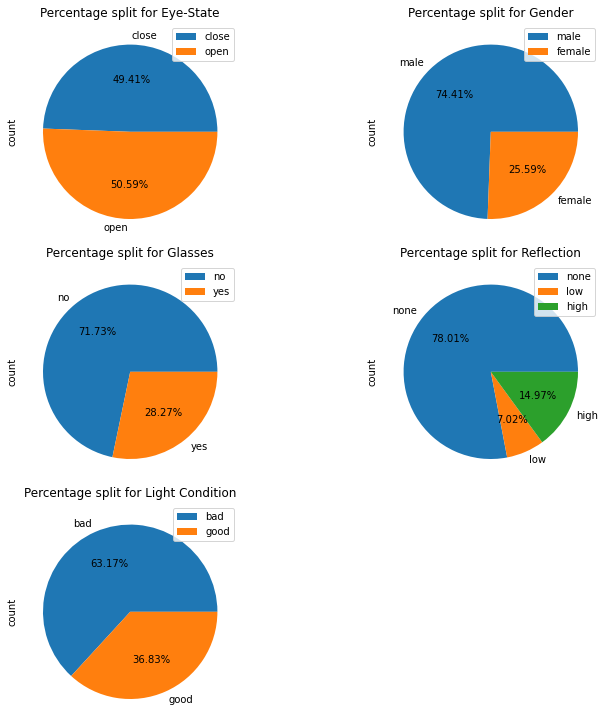

In [25]:
# plotting all the graphs as subplots for easier visualisation
fig_m, axes_m = plt.subplots(nrows = 3, ncols = 2, figsize = (10, 10), constrained_layout=True)
axes_m[2,1].set_visible(False)

eye_state_df.plot.pie(ax = axes_m[0,0], y='count', labels=eye_state_df['eye_state'], autopct='%.2f%%', title='Percentage split for Eye-State')
gender_df.plot.pie(ax = axes_m[0,1], y='count', labels=gender_df['gender'], autopct='%.2f%%', title='Percentage split for Gender')
glasses_df.plot.pie(ax = axes_m[1,0], y='count', labels=glasses_df['glasses'], autopct='%.2f%%', title='Percentage split for Glasses')
reflection_df.plot.pie(ax = axes_m[1,1], y='count', labels=reflection_df['reflection'], autopct='%.2f%%', title='Percentage split for Reflection')
light_condition_df.plot.pie(ax = axes_m[2,0], y='count', labels=light_condition_df['light_condition'], autopct='%.2f%%', title='Percentage split for Light Condition')

plt.show()

# 6. Getting percentage split for samples for each attribute per eye-state

## 6.1 Creating dataframe with specific attributes

In [26]:
per_gender_df = get_combined_df(raw_data_df, 'gender', ['gender', 'eye_state'], 'eye_state', {'0': 'male', '1': 'female'} )
per_glasses_df = get_combined_df(raw_data_df, 'glasses', ['glasses', 'eye_state'], 'eye_state', {'0': 'no', '1': 'yes'} )
per_reflection_df = get_combined_df(raw_data_df, 'reflection', ['reflection', 'eye_state'], 'eye_state', {'0': 'none', '1': 'low', '2': 'high'} )
per_light_condition_df = get_combined_df(raw_data_df, 'light_condition', ['light_condition', 'eye_state'], 'eye_state', {'0': 'bad', '1': 'good'} )

In [27]:
#checking the count of samples for each attribute
print(per_gender_df)
print(per_glasses_df)
print(per_reflection_df)
print(per_light_condition_df)

            male  female
eye_state               
0          30554   11392
1          32619   10333
              no    yes
eye_state              
0          27678  14268
1          33219   9733
            none   low  high
eye_state                   
0          36100  1808  4038
1          30127  4154  8671
             bad   good
eye_state              
0          29913  12033
1          23717  19235


## 6.2 Plotting all the dataframes

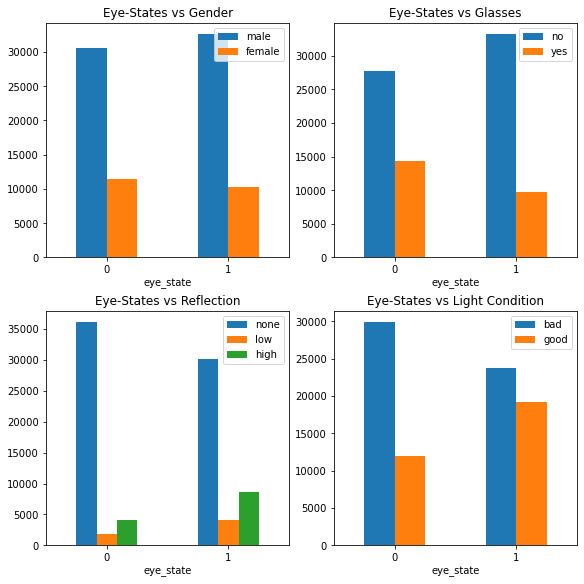

In [28]:
# plotting all the graphs as subplots for easier visualisation
fig_p, axes_p = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 8), constrained_layout=True)

per_gender_df.plot.bar(ax = axes_p[0,0], rot=0, title='Eye-States vs Gender')
per_glasses_df.plot.bar(ax = axes_p[0,1], rot=0, title='Eye-States vs Glasses')
per_reflection_df.plot.bar(ax = axes_p[1,0], rot=0, title='Eye-States vs Reflection')
per_light_condition_df.plot.bar(ax = axes_p[1,1], rot=0, title='Eye-States vs Light Condition')

plt.show()

# 7. Creating random datasets

## 7.1 Checking if any previously created datasets exist

In [29]:
#gets all the sub-directories matching the pattern specified i.e., ending in 'PART_'
sub_dir_list = glob.glob(f'{CAT_DIR}\\{SUB_DIR}*')

In [30]:
#getting the count and if there any sub-directories
count_sub = len(sub_dir_list)
print(f'{count_sub} sub-directories were found in {CAT_DIR} directory.')

3 sub-directories were found in MRL_DS_CAT directory.


In [31]:
#if there any, delete them
if count_sub > 0:
    for sub_dir in sub_dir_list:
        #deleting each sub-directory
        shutil.rmtree(f'{sub_dir}')
        print(f'Deleted path: {sub_dir}')

Deleted path: MRL_DS_CAT\PART_1
Deleted path: MRL_DS_CAT\PART_2
Deleted path: MRL_DS_CAT\PART_3


In [32]:
#creating new random datasets
create_dataset(MAX_DATASETS, per_subject_path, per_dataset_path, MAX_NUM_FILES, s_regex_patterns_list)

Total files copied in dataset 1: 2055
Total files copied in dataset 2: 2055
Total files copied in dataset 3: 2055


## 7.2 Checking the sample count for each category in our custom-dataset

In [33]:
#geting sub-directories once again to check for file count i.e., if it is balanced now
sub_dir_list = glob.glob(f'{CAT_DIR}\\{SUB_DIR}*')

In [34]:
#getting count of files for each category
pattern_file_count = get_pattern_count(sub_dir_list[0], s_regex_patterns_list)

In [35]:
#viewing the counts
pattern_file_count

,regex_pattern,file_count
0,*_0_0_0_0_0_*.png,50
1,*_0_0_0_0_1_*.png,50
2,*_0_0_0_1_0_*.png,0
3,*_0_0_0_1_1_*.png,50
4,*_0_0_0_2_0_*.png,0
5,*_0_0_0_2_1_*.png,50
6,*_0_0_1_0_0_*.png,50
7,*_0_0_1_0_1_*.png,50
8,*_0_0_1_1_0_*.png,50
9,*_0_0_1_1_1_*.png,50
